In [1]:
import sys
sys.path.append('..')

In [16]:
import html
import os
from pathlib import Path

import io
import chromadb
import lovely_tensors as lt
import ollama
import torch
from dotenv import load_dotenv
from langchain.chat_models.openai import ChatOpenAI
from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_community.document_loaders.wikipedia import WikipediaLoader
from langchain_community.graphs import Neo4jGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_text_splitters import TokenTextSplitter
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer
from unidecode import unidecode

from llavart.models.prompting import *
from llavart.models.retriever.modeling import MultiModalSentEmbedder
from llavart.utils.dirutils import get_data_dir, get_store_dir, get_model_checkpoints_dir
import glob
from llavart.data.datasets.image_text_dataset import ImageTextDataset

lt.monkey_patch()
load_dotenv()

True

In [4]:
transform = Compose([Resize(224), CenterCrop(224), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = ImageTextDataset(
    get_data_dir() / "texts" / "wiki_img_paragraph_clean.csv",
    get_data_dir() / "wikipedia_images",
    split="val",
    transform=transform,
)

In [18]:
# go from pixel_values to PIL
def get_pil(sample):
    img = sample["image"]
    img = img.permute(1, 2, 0)
    # denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = (img * 255).byte()
    img = Image.fromarray(img.numpy())
    return img

In [46]:
messages = [
    {"role": "system", "content": f"You are a helpful AI question generator. You will be given an image and a correlated text and you have to create a question about the image which can be answered exclulsively using that text. Refer to elements of the image using 'this' or 'these' (e.g. Who is this person?). You have to write the question not the answer."}
]

In [47]:
dataset[0]

{'image': tensor[3, 224, 224] n=150528 (0.6Mb) x∈[-2.118, 2.553] μ=1.345 σ=1.265,
 'text': 'Man of Earth is a science fiction novel by American writer Algis Budrys, first published in 1958 by Ballantine Books. "The Man from Earth", a "greatly different" earlier version of the story, was published in the debut issue of Satellite Science Fiction in 1956.'}

In [48]:
image_byte_array = io.BytesIO()
get_pil(dataset[0]).save(image_byte_array, format='JPEG')
image_byte_array.seek(0)

0

In [49]:
user_message = {"role": "user", "content": dataset[0]["text"], "images": [image_byte_array]}
new_messages = messages + [user_message]

In [50]:
new_messages

[{'role': 'system',
  'content': "You are a helpful AI question generator. You will be given an image and a correlated text and you have to create a question about the image which can be answered exclulsively using that text. Refer to elements of the image using 'this' or 'these' (e.g. Who is this person?). You have to write the question not the answer."},
 {'role': 'user',
  'content': 'Man of Earth is a science fiction novel by American writer Algis Budrys, first published in 1958 by Ballantine Books. "The Man from Earth", a "greatly different" earlier version of the story, was published in the debut issue of Satellite Science Fiction in 1956.',
  'images': [<_io.BytesIO at 0x7e767b680f40>]}]

In [51]:
res = ollama.chat(
	model="llava:13b",
	messages=new_messages,
    options={
        "temperature": 1.5,
        "seed": 42
    }
)

print(res['message']['content'])

 This image features the cover of a book titled "Man of Earth" by Algis Budrys. The cover art depicts an apocalyptic scene where a large, red and black explosion seems to be occurring on the land, which appears barren and in ruins. There are two silhouetted figures near the bottom of the image that appear to be observing the destruction from afar. The style of the cover art is abstract, using geometric shapes and colors that convey a sense of chaos and destruction.


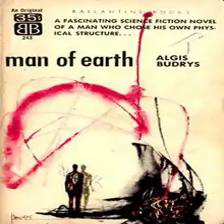

('Man of Earth is a science fiction novel by American writer Algis Budrys, first published in 1958 by Ballantine Books. "The Man from Earth", a "greatly different" earlier version of the story, was published in the debut issue of Satellite Science Fiction in 1956.',
 None)

In [45]:
dataset[0]["text"], display(get_pil(dataset[0]))